In [1]:
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gmean
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from doe_modules.preferences import kwarg_savefig, outputdir
from doe_modules.ml import plot_pr, plot_roc
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score
from sklearn.linear_model import LogisticRegression

from doe_modules.simulation.esm4_metrics import *

In [2]:
top10 = np.array([
    "positive_pathway_coverage", 
    "max_positive_edge_density", 
    "max_positive_cascade_length_ratio", 
    "edge_effectivity",
    "mean_factor_density",
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "pathway_coverage",
    "max_cascade_length_ratio",
    "effective_edge_positivity"
])

negs = [
    "max_positive_edge_density", 
    "max_positive_cascade_length_ratio", 
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "effective_edge_positivity"
]

key_features = [
    "positive_pathway_coverage", 
    "max_positive_edge_density", 
    "max_synergetic_edge_density",
    "mean_positive_edge_density",
    "pathway_coverage",
    "effective_edge_positivity"
]

In [3]:
from tqdm.notebook import tqdm

edges = np.array(list(map(list, product([-1, 0, 1], repeat=10))))

n = (lambda arr: (-1 + np.sqrt(1 + 8 * arr.size)) / 2)(edges[0])
ppc = np.fromiter(map(positive_pathway_coverage, edges), float).reshape(-1, 1)
maxped = np.fromiter(map(lambda arr: 1 - max_positive_edge_density(arr), edges), float).reshape(-1, 1)
maxsed = np.fromiter(map(lambda arr: 1 - max_synergetic_edge_density(arr), edges), float).reshape(-1, 1)
meanped = np.fromiter(map(lambda arr: 1 - mean_positive_edge_density(arr), edges), float).reshape(-1, 1)
pc = np.fromiter(map(pathway_coverage, edges), float).reshape(-1, 1)
eep = np.fromiter(map(lambda arr: 1 - effective_edge_positivity(arr), edges), float).reshape(-1, 1)

full = np.hstack([ppc, maxped, maxsed, meanped, pc, eep])

arr_top10 = np.hstack([
    np.fromiter(
        map(
            (lambda arr: 1 - eval(f)(arr)) if f in negs else eval(f), 
            edges
        ), float
    ).reshape(-1, 1) for f in top10
])


df = pd.concat(
    [
        pd.read_feather(f"{outputdir}/esm_test4.feather"),
        pd.DataFrame(
            arr_top10,
            columns=top10
        ),
        pd.DataFrame({
            f"arithmetic{i + 1}": mat.mean(axis=1) for i, mat in tqdm(enumerate(
                [
                    full[:, np.where(arr_bool)[0]] for arr_bool in map(
                        lambda lst_bool: np.array(lst_bool), 
                        product(*[[True, False]] * 6)
                    ) if arr_bool.sum() > 1
                ]
            ))
        })
    ],
    axis=1
)

df = df.assign(
    better_with_pb=df.pb > df.cloo
)

0it [00:00, ?it/s]

In [4]:
df

,cloo,pb,v,,positive_pathway_coverage,max_positive_edge_density,max_positive_cascade_length_ratio,edge_effectivity,mean_factor_density,max_synergetic_edge_density,...,arithmetic49,arithmetic50,arithmetic51,arithmetic52,arithmetic53,arithmetic54,arithmetic55,arithmetic56,arithmetic57,better_with_pb
0,0.000000,0.000000,0,neither,0.0,1.00,1.00,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,False
1,0.000000,0.000000,0,neither,0.0,1.00,1.00,1.0,0.9,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,False
2,0.000000,0.000000,0,neither,0.0,1.00,1.00,1.0,1.0,0.833333,...,0.888889,0.916667,0.888889,0.916667,0.833333,0.944444,1.00,0.916667,0.916667,False
3,0.000000,0.000000,0,neither,0.0,1.00,1.00,1.0,1.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,False
4,0.000000,0.000000,0,neither,0.0,1.00,1.00,1.0,0.8,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00,1.000000,1.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59044,0.750000,0.750000,3,both,1.0,0.25,0.25,1.0,0.8,0.250000,...,0.250000,0.375000,0.416667,0.625000,0.125000,0.500000,0.75,0.250000,0.500000,False
59045,1.000000,0.750000,1,C+LOO,1.0,0.00,0.00,1.0,1.0,0.000000,...,0.033333,0.050000,0.333333,0.500000,0.000000,0.366667,0.55,0.050000,0.500000,False
59046,0.333333,-0.333333,0,neither,1.0,0.50,0.25,1.0,1.0,0.500000,...,0.322222,0.400000,0.555556,0.750000,0.333333,0.488889,0.65,0.233333,0.583333,False
59047,0.750000,0.750000,3,both,1.0,0.40,0.25,1.0,0.9,0.400000,...,0.233333,0.350000,0.466667,0.700000,0.200000,0.433333,0.65,0.150000,0.500000,False


def cai_performance(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return np.vectorize(lambda t: metric(data.cloo < data.pb, data.cai <= t))(xrange)

def cai_performance_plot(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    return (xrange, cai_performance(data, metric, xrange))

def argmax_cai(data, metric, xrange = None):
    xrange = np.linspace(0, 1, 1001) if xrange is None else xrange
    y = cai_performance(data, metric, xrange)
    argmax = np.argmax(y)
    return (xrange[argmax], y[argmax])

In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, average_precision_score, f1_score, recall_score, precision_score, precision_recall_curve

fig, ax = plt.subplots()

nx = np.linspace(1, 10, 10)

ax.plot(nx, np.vectorize(lambda x: x / (1 + x))(nx), label="x/(1+x)", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 / (1 + np.e ** (-x)))(nx), label="1/(1+e^-x)", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 - np.e ** (-x))(nx), label="1 - e^-x", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 - (1 / x))(nx), label="div2", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 - (1 /  (x ** 2)))(nx), label="a", marker="o")
ax.plot(nx, np.vectorize(lambda x: 1 - (1 /  (x ** .5)))(nx), label="div3", marker="o")

ax.legend()

In [6]:
def div22():
    weight = np.array([1 / n, 1 - (1 / n)])
    val = np.hstack([
        ppc, 
        maxped
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div3():
    weight = np.array([1, n, (n + 1) * (n - 1), 1])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div1234():
    weight = np.array([1, n, n ** 2, 1])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div123():
    weight = np.array([1, n, n ** 2])
    val = np.hstack([
        ppc, 
        maxped,
        meanped,
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div234():
    weight = np.array([n, n ** 2, 1])
    val = np.hstack([
        maxped,
        meanped,
        pc
    ])
    return (weight * val).sum(axis=1) / weight.sum()


def div23():
    weight = np.array([n, n ** 2])
    val = np.hstack([
        maxped,
        meanped,
    ])
    return (weight * val).sum(axis=1) / weight.sum()

In [7]:
# df = pd.concat(
#     [
#         df, 
#         pd.DataFrame(dict(
#             div22=div22(),
#             div3=div3(),
#             div1234=div1234(),
#             div123=div123(),
#             div234=div234(),
#             div23=div23()
#         ))
#     ],
#     axis=1
# )

df

from sklearn.metrics import f1_score

fig, ax = plt.subplots()

thresh = np.linspace(0, 1, 11)
hoge = pd.DataFrame({
    "thresh": thresh,
    # "div22": np.vectorize(lambda t: f1_score(df.better_with_pb, df.div22 > t))(thresh),
    "arithmetric1": np.vectorize(lambda t: f1_score(df.better_with_pb, df.arithmetic1 > t))(thresh),
    "ppc": np.vectorize(lambda t: f1_score(df.better_with_pb, df.positive_pathway_coverage > t))(thresh),
    "mped": np.vectorize(lambda t: f1_score(df.better_with_pb, df.max_positive_edge_density > t))(thresh),
})

for key in [
    # "div22", 
    "arithmetric1", "ppc", "mped"]:
    sns.lineplot(
        data=hoge, x="thresh", y=key, label=key, marker="o"
    )

In [8]:
feat_names_short = dict(
    pathway_coverage=r"P%",
    pathway_positivity=r"P$_{(+)}$/P",
    pathway_negativity=r"P$_{(-)}$/P",
    positive_pathway_coverage=r"P$_{(+)}$%",
    negative_pathway_coverage=r"P$_{(-)}$%",
    sparse_pathway_coverage=r"P$_{(0)}$%",
    edge_coverage=r"R%",
    edge_positivity=r"R$_{(+)}$/R",
    edge_negativity=r"R$_{(-)}$/R",
    positive_edge_coverage=r"R$_{(+)}$%",
    negative_edge_coverage=r"R$_{(-)}$%",
    sparse_edge_coverage=r"R$_{(0)}$%",
    edge_effectivity=r"R$^*$/R",
    effective_edge_positivity=r"R$^*_{(+)}$/R$^*$",
    effective_edge_negativity=r"R$^*_{(-)}$/R$^*$",
    max_edge_density=r"MaxRW/R$^*$",
    mean_edge_density=r"RW%",
    max_positive_edge_density=r"MaxRW$_{(+)}$/R$^*$",
    mean_positive_edge_density=r"RW$_{(+)}$%",
    max_synergetic_edge_density=r"MaxRW$_&$/R$^*$",
    mean_synergetic_edge_density=r"RW$_&$%",
    max_factor_density=r"MaxFW/n",
    mean_factor_density=r"FW%",
    max_positive_factor_density=r"MaxFW$_{(+)}$/n",
    mean_positive_factor_density=r"FW$_{(+)}$%",
    max_synergetic_factor_density=r"MaxFW$_&$/n",
    mean_synergetic_factor_density=r"FW$_&$%",
    max_cascade_length_ratio=r"MaxCL/n",
    mean_cascade_length_ratio=r"CL%",
    max_positive_cascade_length_ratio=r"MaxCL$_{(+)}$/n",
    mean_positive_cascade_length_ratio=r"CL$_{(+)}$%",
    max_synergetic_cascade_length_ratio=r"MaxCL$_&$/n",
    mean_synergetic_cascade_length_ratio=r"CL$_&$%",
    # cascade_coverage=r"C%",
    # positive_cascade_coverage=r"C$_+$%",
    # synergetic_cascade_coverage=r"C$_&$%",
)

In [76]:
names

['P$_{(+)}$%',
 '$1-$MaxRW$_{(+)}$/R$^*$',
 '$1-$MaxCL$_{(+)}$/n',
 'R$^*$/R',
 'FW%',
 '$1-$MaxRW$_&$/R$^*$',
 '$1-$RW$_{(+)}$%',
 'P%',
 'MaxCL/n',
 '$1-$R$^*_{(+)}$/R$^*$']

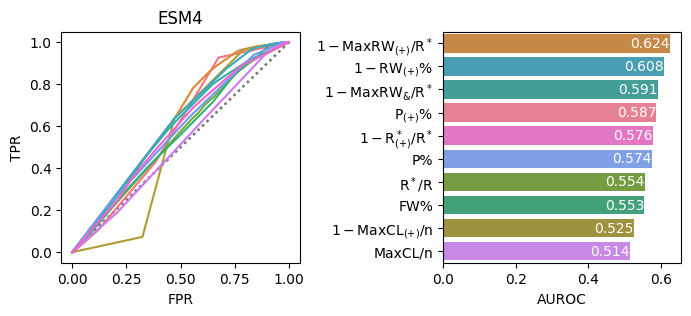

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=.6)

features = [df.loc[:, v] for v in top10]

names = [
    r"$1-$" + feat_names_short[v] if v in negs else feat_names_short[v] for v in top10
]


cmap = sns.color_palette("husl", len(features))

df_bar = pd.DataFrame({
    "": names,
    "AUROC": [roc_auc_score(df.better_with_pb, y) for y in features],
    "cmap": cmap
}, index=top10).sort_values("AUROC", ascending=False)

sns.barplot(
    data=df_bar, x="AUROC", y="",
    hue="", legend=False, ax=ax[1],
    palette=df_bar.cmap.values.tolist()
)

for i, y in enumerate(features):
    ax[0].plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i],
        # + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax[0].plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
    
    auroc = roc_auc_score(df.better_with_pb, y)
    
    ax[1].text(
        auroc, 
        np.where(df_bar.loc[:, ""] == names[i])[0].item(), 
        auroc.round(3), ha="right", va="center", color="w"
    )

# ax[0].legend(fontsize="x-small", loc="upper center", bbox_to_anchor=(.5, -.2), ncol=2)
ax[0].set(title="ESM4", xlabel="FPR", ylabel="TPR")

fig.savefig(f"{outputdir}/test4_roc", **kwarg_savefig)

In [66]:
# fig, ax = plt.subplots(figsize=(3, 3))

# features = [df.loc[:, v] for v in top10]

# names = [
#     r"$1-$" + feat_names_short[v] if v in negs else feat_names_short[v] for v in top10
# ]


# cmap = sns.color_palette("husl", len(features))

# for i, y in enumerate(features):
#     ax.plot(
#         *roc_curve(df.better_with_pb, y)[:2], 
#         label=names[i],
#         # + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
#         c=cmap[i]
#     )
#     ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

# ax.legend(fontsize="x-small", loc="upper center", bbox_to_anchor=(.5, -.2), ncol=2)
# ax.set(title="ESM4", xlabel="FPR", ylabel="TPR")

# fig.savefig(f"{outputdir}/test4_roc", **kwarg_savefig)

In [67]:
# fig, ax = plt.subplots(figsize=(3, 3))

# features = [df.loc[:, v] for v in top10]

# names = [
#     r"$1-$" + feat_names_short[v] if v in negs else feat_names_short[v] for v in top10
# ]

# cmap = sns.color_palette("husl", len(features))

# df_bar = pd.DataFrame({
#     "": names,
#     "AUROC": [roc_auc_score(df.better_with_pb, y) for y in features],
#     "cmap": cmap
# }, index=top10).sort_values("AUROC", ascending=False)

# sns.barplot(
#     data=df_bar, x="AUROC", y="",
#     hue="", legend=False,
#     palette=df_bar.cmap.values.tolist()
# )

# fig.savefig(f"{outputdir}/test4_auc", **kwarg_savefig)

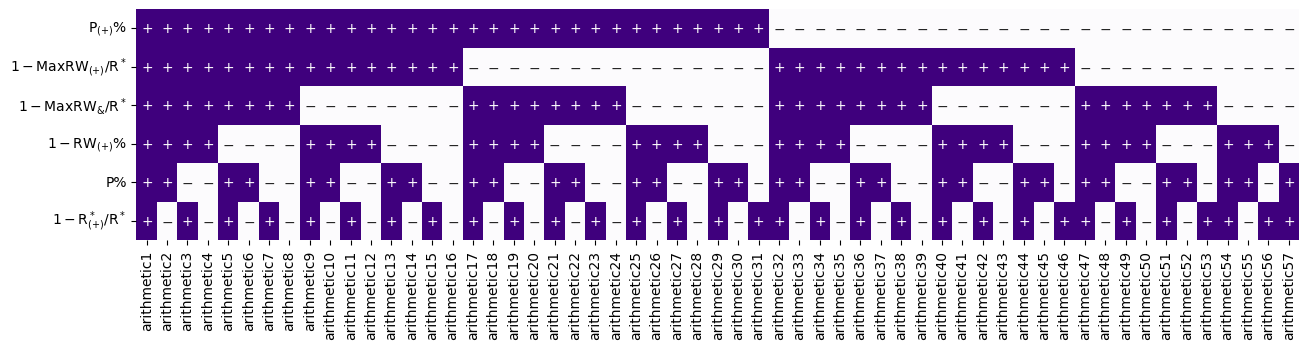

In [26]:
fig, ax = plt.subplots(figsize=(15, 3))

arr_condition = np.vstack([
    arr_bool for arr_bool in map(
        lambda lst_bool: np.array(lst_bool), 
        product(*[[True, False]] * 6)
    ) if arr_bool.sum() > 1
])

df_arr_condition = pd.DataFrame(
    arr_condition,
    index=[f"arithmetic{i + 1}" for i in range(57)],
    columns=[
        r"$1-$" + feat_names_short[v] if v in negs else feat_names_short[v] for v in key_features
    ]
).T

sns.heatmap(
    data=df_arr_condition,
    cbar=False, 
    fmt="s",
    annot=df_arr_condition.applymap(
        lambda x: "$+$" if x else "$-$"
    ),
    cmap="Purples"
)

fig.savefig(f"{outputdir}/test4_arithmetic_conditions", **kwarg_savefig)

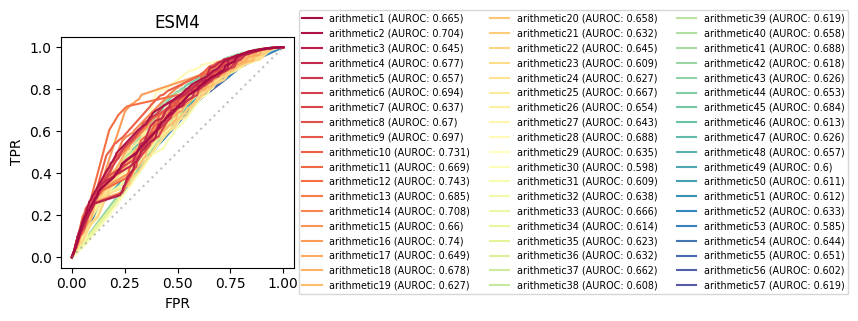

In [43]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [
    eval("df.arithmetic" + f"{i + 1}") for i in range(57)
]

names = [
    f"arithmetic{i + 1}" for i in range(57)
]


cmap = sns.color_palette("Spectral", len(features))

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i],
        zorder=-i
    )

ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5), ncol=3)
ax.set(title="ESM4", xlabel="FPR", ylabel="TPR")

fig.savefig(f"{outputdir}/test4_roc_arithmetic", **kwarg_savefig)

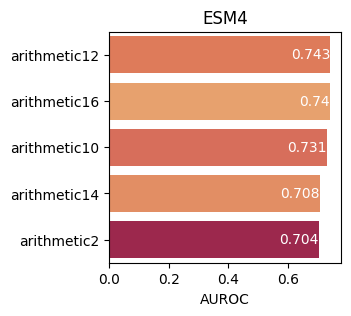

In [114]:
fig, ax = plt.subplots(figsize=(3, 3))

features = [
    eval("df.arithmetic" + f"{i + 1}") for i in range(57)
]

names = [
    f"arithmetic{i + 1}" for i in range(57)
]

df_bar_arith = pd.DataFrame({
    "": names,
    "AUROC": [roc_auc_score(df.better_with_pb, y) for y in features],
    "cmap": sns.color_palette("Spectral", len(features))
}, index=names).sort_values("AUROC", ascending=False).iloc[:5, :]

sns.barplot(
    data=df_bar_arith,
    x="AUROC", y="",
    hue="", legend=False,
    palette=df_bar_arith.cmap.values.tolist()
)

for i, auroc in enumerate(df_bar_arith.AUROC):
    ax.text(
        auroc, i, round(auroc, 3), 
        ha="right", va="center", color="w"
    )

ax.set(title="ESM4")

fig.savefig(f"{outputdir}/test4_auc_arithmetic", **kwarg_savefig)

In [117]:
pbsi_features = [
    'positive_pathway_coverage',
    'max_positive_edge_density',
    'mean_positive_edge_density',
]

[Text(0.5, 1.0, 'ESM4'), Text(0.5, 0, 'FPR'), Text(0, 0.5, 'TPR')]

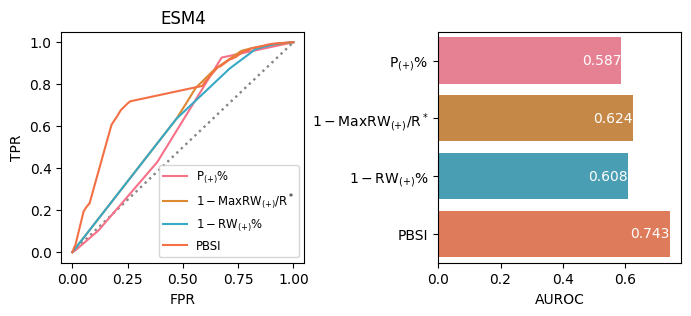

In [118]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
plt.subplots_adjust(wspace=.55)

df_concat = pd.concat(
    [
        # df_bar.loc[[v for v in df_bar.loc[top10, :].index if v in key_features], :],
        df_bar.loc[[v for v in df_bar.loc[pbsi_features, :].index], :],
        df_bar_arith.iloc[:1, :]
    ],
    axis=0
)

features = [
    df.loc[:, v] for v in df_concat.index
]

names = [
    r"$1-$" + feat_names_short[v] if v in negs else v for v in df_concat.index
]

names = [
    feat_names_short[v] if v in key_features else v for v in names
]

names = [
    "PBSI" if "arithmetic" in v else v for v in names
]


cmap = df_concat.cmap

df_bar_concat = pd.DataFrame({
    "": names,
    "AUROC": [roc_auc_score(df.better_with_pb, y) for y in features],
    "cmap": df_concat.cmap
}, index=df_concat.index)
# .sort_values("AUROC", ascending=False)

sns.barplot(
    data=df_bar_concat, x="AUROC", y="",
    hue="", legend=False, ax=ax[1],
    palette=df_bar_concat.cmap.values.tolist()
)

for i, y in enumerate(features):
    ax[0].plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i], 
        # + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax[0].plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
    
    ax[1].text(
        df_bar_concat.AUROC[i], 
        np.where(df_bar_concat.loc[:, ""] == names[i])[0].item(), 
        df_bar_concat.AUROC[i].round(3), ha="right", va="center", color="w"
    )

ax[0].legend(fontsize="small", loc="lower right")
ax[0].set(title="ESM4", xlabel="FPR", ylabel="TPR")

# fig.savefig(f"{outputdir}/test4_roc_integrated", **kwarg_savefig)

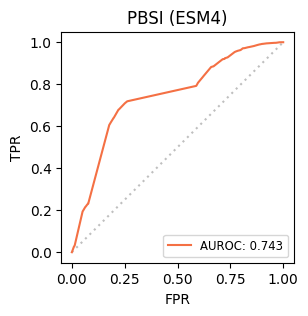

In [119]:
fig, ax = plt.subplots(figsize=(3, 3))

df_concat = df_bar_arith.iloc[:1, :]

features = [
    df.loc[:, v] for v in df_concat.index
]

names = ["PBSI"]


cmap = df_concat.cmap

for i, y in enumerate(features):
    ax.plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        # label=names[i] + 
        label=f"AUROC: {roc_auc_score(df.better_with_pb, y).round(3)}", 
        c=cmap[i]
    )
    ax.plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="small", loc="lower right")
ax.set(title="PBSI (ESM4)", xlabel="FPR", ylabel="TPR")

fig.savefig(f"{outputdir}/test4_roc_integrated", **kwarg_savefig)

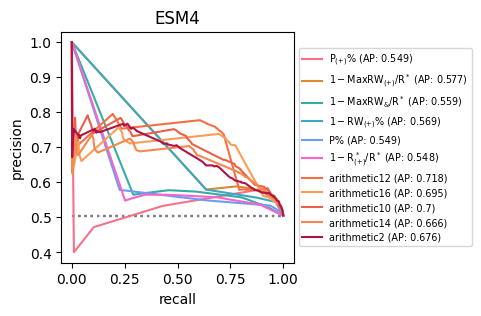

In [34]:
fig, ax = plt.subplots(figsize=(3, 3))

for i, y in enumerate(features):
    ax.plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + f" (AP: {average_precision_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    base = df.better_with_pb.value_counts().cumsum()[0] / df.better_with_pb.value_counts().cumsum()[1]
    ax.plot([0, 1], [base, base], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax.legend(fontsize="x-small", loc="center left", bbox_to_anchor=(1, .5))
ax.set(title="ESM4", xlabel="recall", ylabel="precision")

fig.savefig(f"{outputdir}/test4_pr", **kwarg_savefig)

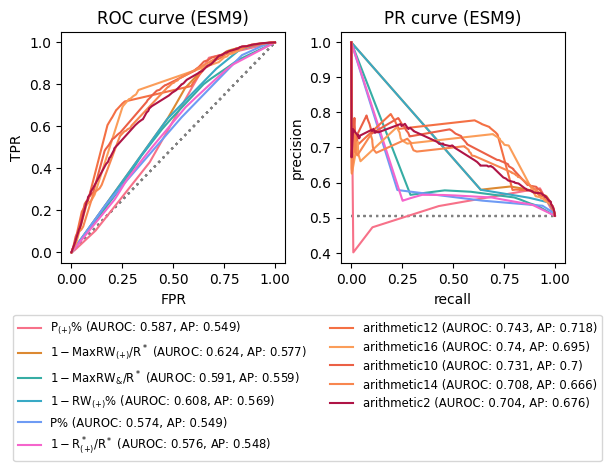

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 3))
plt.subplots_adjust(wspace=.25)

df_concat = pd.concat(
    [
        df_bar.loc[[v for v in df_bar.loc[key_features, :].index if v in key_features], :],
        df_bar_arith
    ],
    axis=0
)

features = [
    df.loc[:, v] for v in df_concat.index
]

names = [
    r"$1-$" + feat_names_short[v] if v in negs else v for v in df_concat.index
]

names = [
    feat_names_short[v] if v in key_features else v for v in names
]


cmap = df_concat.cmap

for i, y in enumerate(features):
    ax[0].plot(
        *roc_curve(df.better_with_pb, y)[:2], 
        label=names[i] + f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)})", 
        c=cmap[i]
    )
    ax[0].plot([0, 1], [0, 1], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)
    ax[1].plot(
        *precision_recall_curve(df.better_with_pb, y)[:2][::-1], 
        label=names[i] + \
        f" (AUROC: {roc_auc_score(df.better_with_pb, y).round(3)}, " + \
        f"AP: {average_precision_score(df.better_with_pb, y).round(3)})" , 
        c=cmap[i]
    )
    base = df.better_with_pb.value_counts().cumsum()[0] / df.better_with_pb.value_counts().cumsum()[1]
    ax[1].plot([0, 1], [base, base], linestyle=(0, (1, 2)), c="gray", zorder=1, alpha=0.5)

ax[1].legend(fontsize="small", loc="upper center", bbox_to_anchor=(-.15, -.2), ncol=2)
ax[0].set(
    title="ROC curve (ESM9)", xlabel="FPR", ylabel="TPR"
)
ax[1].set(title="PR curve (ESM9)", xlabel="recall", ylabel="precision")

fig.savefig(f"{outputdir}/test4_roc_pr_integrated", **kwarg_savefig)

In [16]:
from sklearn.metrics import confusion_matrix

In [17]:
def tp(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    return mat[1, 1] / mat[1].sum()

def fp(y_true, y_pred):
    mat = confusion_matrix(y_true, y_pred)
    return mat[0, 1] / mat[0].sum()

In [24]:
vals = np.sort(df.arithmetic12.unique())

fps = np.vectorize(
    lambda t: fp(df.better_with_pb, df.arithmetic12 > t)
)(vals)

tps = np.vectorize(
    lambda t: tp(df.better_with_pb, df.arithmetic12 > t)
)(vals)

acc = np.vectorize(
    lambda t: accuracy_score(df.better_with_pb, df.arithmetic12 > t)
)(vals)

f1 = np.vectorize(
    lambda t: f1_score(df.better_with_pb, df.arithmetic12 > t)
)(vals)

NameError: name 'vals' is not defined

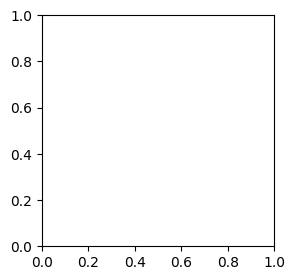

In [120]:
fig, ax = plt.subplots(figsize=(3, 3))

# thresh = np.linspace(0, 1, 21)
df_thresh = pd.DataFrame({
    "thresh": vals,
    "accuracy": acc,
    "$F_1$": f1,
    "TPR $-$ FPR": tps - fps,
})


metrics = np.array(["accuracy", "$F_1$", "TPR $-$ FPR"])
thresh_recorder = {}
cmap = [
    plt.cm.managua(
        (i + 1) / (metrics.size + 1)
    ) for i in range(metrics.size)
]

for i, key in enumerate(metrics):
    v = df_thresh.loc[:, key].values
    argmax = np.argmax(v)

    sns.lineplot(
        data=df_thresh, x="thresh", y=key, 
        label=f"{key} (argmax: {vals[argmax].round(3)})",
        c=cmap[i]
    )
    # ax.text(
    #     vals[argmax], v[argmax], vals[argmax].round(3),
    #     ha="center", va="bottom", c=cmap[i]
    # )
    # ax.text(
    #     vals[0], v[0], key, ha="left", 
    #     va="bottom" if v[0] < .5 else "top", c=cmap[i]
    # )
    thresh_recorder = {**thresh_recorder, key: vals[argmax]}
    

ax.set(
    title="ESM4",
    xlabel="thresholds in PBSI", ylabel="scores",
    ylim = np.array(ax.get_ylim()) + np.array([0, .3])
)
ax.legend(fontsize="x-small")

In [ ]:
vals = np.sort(df.arithmetic2.unique())
# vals = thresh

thresh_recorder = {
    v:  vals[np.argmax(
        np.vectorize(lambda t: eval(f"{v}_score")(
            df.better_with_pb, df.arithmetic12 > t
        ))(vals)
    )] for v in ["accuracy", "f1"]
}

thresh_recorder

In [ ]:
fig, ax = plt.subplots()

thresh = np.linspace(0, 1, 21)
hoge = pd.DataFrame({
    "thresh": thresh,
    "arithmetric12": np.vectorize(lambda t: accuracy_score(df.better_with_pb, df.arithmetic12 > t))(thresh),
    "ppc": np.vectorize(lambda t: accuracy_score(df.better_with_pb, df.positive_pathway_coverage > t))(thresh),
    "mped": np.vectorize(lambda t: accuracy_score(df.better_with_pb, df.max_positive_edge_density > t))(thresh),
})

for key in [
    # "div22", 
    "arithmetric12", "ppc", "mped"]:
    sns.lineplot(
        data=hoge, x="thresh", y=key, label=key, marker="o"
    )